In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import control as ctl

# OBTENDO A BASE DE DADOS
Os dados abaixo são de uma tabela CSV que mostra o comportamento no tempo da minha saída quando um degrau foi aplicado, eu já sei que esses dados são da função $f(t) = \frac{1}{3}\cdot e^{-t}sin(3t)$ e sua transformada (Função de Transferência) é $G(s) = \frac{1}{s^2 + 2s + 10}$ mas vamos tentar chegar nesse resultado de forma experimental, à medida que nem sempre temos a função de transferência pronta em nossas mãos

- O objetivo é monitorar a saída do sistema, que são os dados do CSV, e montar a função de transferência em cima disso
- Depois devemos laplacear inversamente para voltar ao domínio do tempo e obter a mesma resposta

In [25]:
df = pd.read_csv('DataBase.csv')
df = df.drop(columns=df.columns[0])
df.head(10)

,Tensao,Tempo
0,0.000000,0.000000
1,0.130736,0.159311
2,0.130736,0.159311
3,0.130736,0.159311
4,0.131359,0.160306
5,0.131359,0.160306
6,0.131992,0.161324
7,0.132604,0.162311
8,0.132604,0.162311
9,0.133220,0.163308


# ESBOÇANDO O GRÁFICO NO DOMÍNIO DO TEMPO
O gráfico expressa a função de transferência no domínio do tempo $G(s) = L^{-1}\{g(t)\}$

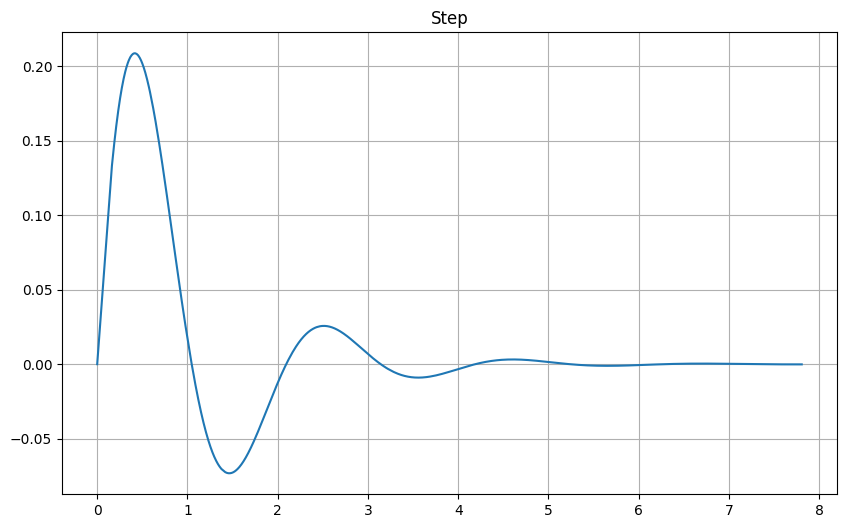

In [26]:
def reduceArray(data, reducedSize):
    indices = np.linspace(0, len(data)-1, reducedSize, dtype=int)
    return data[indices]

yData = np.array(df['Tensao'])
tData = np.array(df['Tempo'])

yData = reduceArray(yData, 5000) # QUERO SÓ 5000 DADOS PRA NÃO DEMORAR
tData = reduceArray(tData, 5000)

df = df.dropna(how='any') # DELETANDO TODAS AS LINHAS EM QUE UM VALOR É NULO
df = df.reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(tData, yData)
plt.title('Step')
plt.grid()
plt.show()

Essa função é bem conhecida e tem a "cara" $f(t) = k \cdot e^{-at + b}\cdot sin(ct + d) + Yo$. Vamos fazer um Data Fitting para encontrar os coeficientes dessa função

# ADAPTANDO OS DADOS PARA UMA FUNÇÃO

In [27]:
# Função para uso com curve_fit (NumPy)
def f(t, k, a, b, c, d, e, Yo):
    return k * np.exp(-a * t + b) * np.sin(c * t + d) + Yo

# Função para representação simbólica (SymPy)
def f_sp(t, k, a, b, c, d, e, Yo):
    return k * sp.exp(-a * t + b) * sp.sin(c * t + d) + Yo

def curveFit(xData, yData, maxfev=1000000000):
    xData = np.array(xData)
    yData = np.array(yData)
    coefs = curve_fit(f, xData, yData, maxfev=1000000000)
    return list(coefs[0])

In [28]:
coefs = curveFit(tData, yData)
t = sp.var('t')    


f = f_sp(t, *coefs)
f

/home/klauss/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


-2.97485048855346e-12 + 0.333333333063112*exp(-0.999999999416767*t)*sin(2.99999999858621*t + 1.41786549365226e-9)

Na prática, podemos eliminar esse $10^{-16}$ porque é erro, a função fica $f(t) = -\frac{1}{3}e^{-t}sin(3t - \pi)$

In [29]:
def roundSympyFunction(expr, num_digits=3):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

f = roundSympyFunction(f)
f

0.333*exp(-1.0*t)*sin(3.0*t)

# COMPARANDO A FUNÇÃO OBTIDA
Vemos que realmente bate com a função que encontramos apenas pelo gráfico de pontos

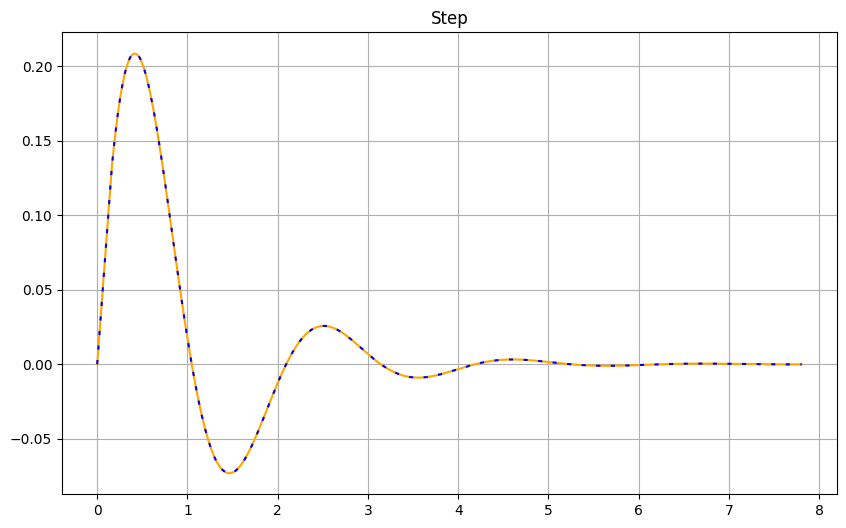

In [30]:
t     = sp.var('t')
yFunc = [f.subs(t, c) for c in tData]

plt.figure(figsize=(10, 6))
plt.plot(tData, yFunc, color='orange')
plt.plot(tData, yData, '--', dashes=[2, 5], color='blue')
plt.title('Step')
plt.grid()
plt.show()

# LAPLACEANDO A FUNÇÃO
Agora temos a função $G(s)$ quando laplaceamos $g(t)$. O gráfico da função será esboçado para confirmar que a função realmente funcionou

In [31]:
def transformadaLaplace(function):   
    t, s = sp.symbols('t s')
    return sp.laplace_transform(function, t, s)[0].expand().simplify()

def transformadaInversaLaplace(function):   
    t, s = sp.symbols('t s')
    return sp.inverse_laplace_transform(function, s, t).expand().simplify()

Y = transformadaLaplace(f)
Y = roundSympyFunction(Y)
display(Y)

0.999/(s**2 + 2.0*s + 10.0)

Que é o mesmo que $Y(s) = \frac{1}{s^2 + 2s + 10}$ mostrada anteriormente. E essa é a nossa função de transferência, para voltar para o domínio do tempo é só aplicar a inversa novamente

In [32]:
f = transformadaInversaLaplace(Y)
f = roundSympyFunction(f)
display(f)

0.333*exp(-1.0*t)*sin(3.0*t)*Heaviside(t)

# FUNÇÃO DE TRANSFERÊNCIA

In [33]:
r = 1
R = transformadaLaplace(r)
R

1/s

In [34]:
G = (Y/R).factor()

G

0.09990234375*s/(0.1*s**2 + 0.2*s + 1.0)

In [35]:
s = ctl.TransferFunction.s
G = eval(str(G))
G

TransferFunction(array([0.09990234, 0.        ]), array([0.1, 0.2, 1. ]))

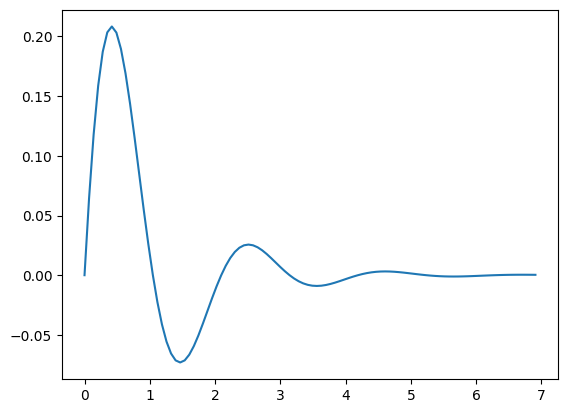

In [36]:
time, response = ctl.step_response(G)
plt.plot(time, response)